<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 10%</h3>

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [4]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [5]:
noise_ratio = 0.1
loss_function = 'DampedMAELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedMAELoss_aircrafts_asym_0.1_0.25_baseline
Model Features: DampedMAELoss_aircrafts_asym_0.1_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedMAELoss_aircrafts_asym_0.1_0.25
Csv save: DampedMAELoss_aircrafts_asym_0.1_0.25
Saving features from Scheme delta = 0.25: DampedMAELoss_aircrafts_asym_0.1_0.5
Saving csv for damp_2: DampedMAELoss_aircrafts_asym_0.1_0.5


In [3]:
architecture = 'efficientnet-b4'


effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [6]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

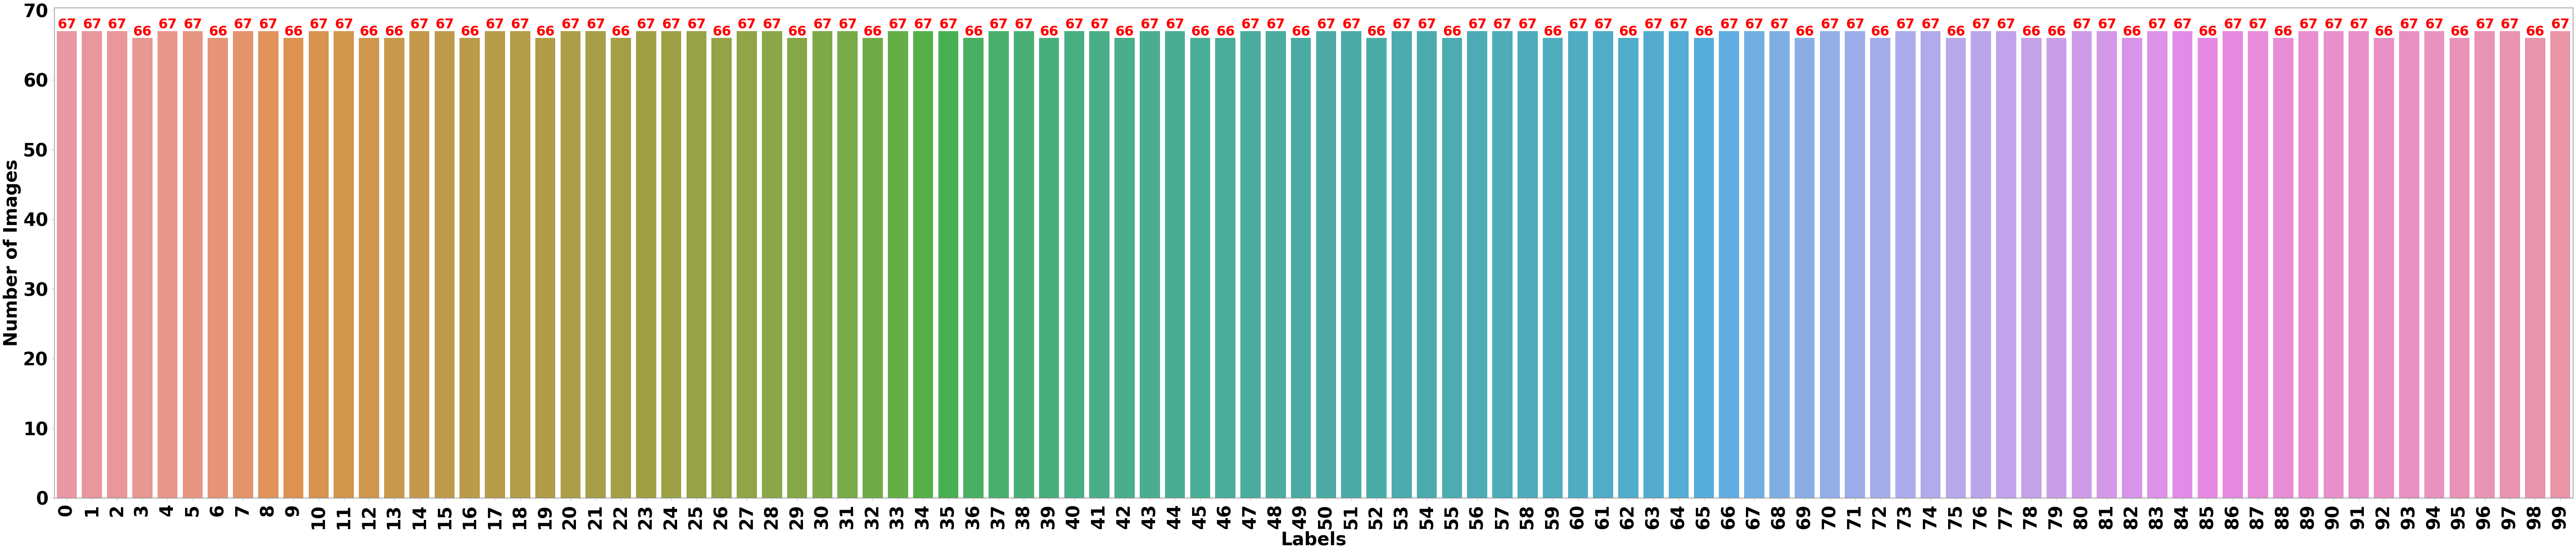

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


Text(0, 0.5, 'Number of Images')

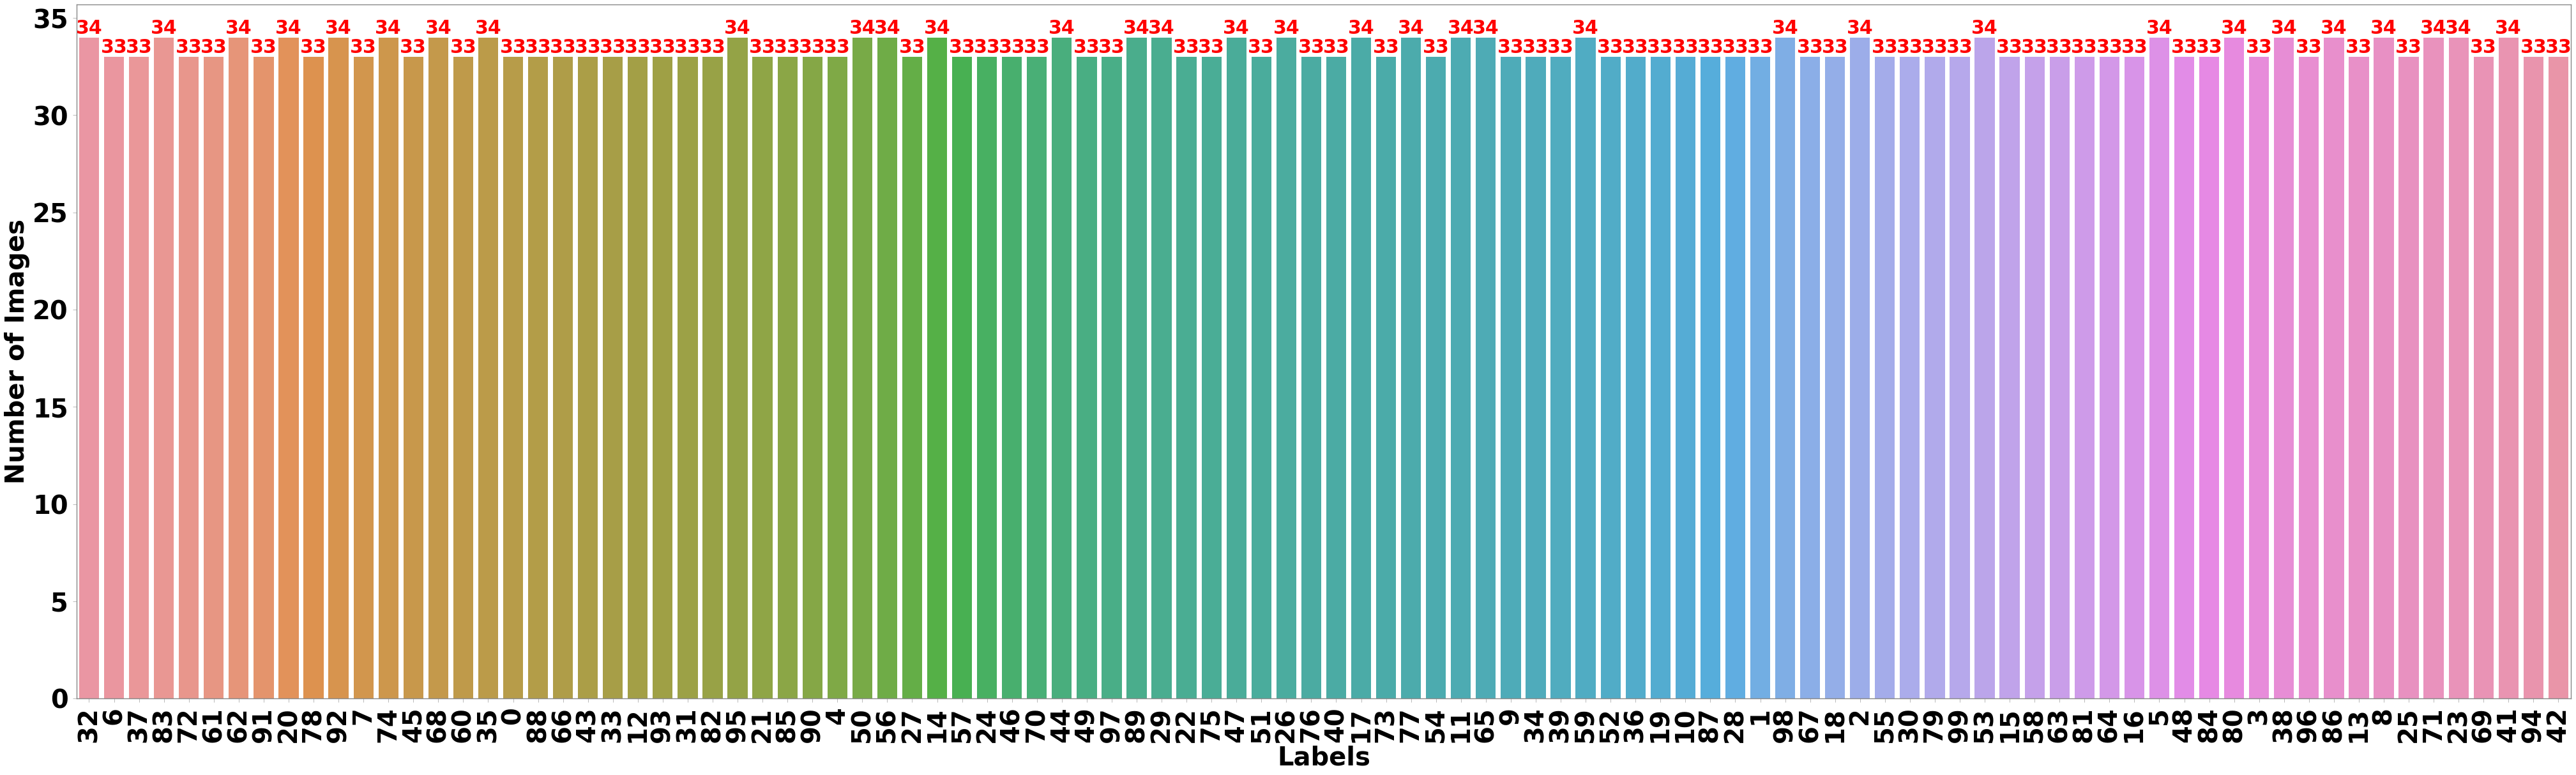

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [13]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [14]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


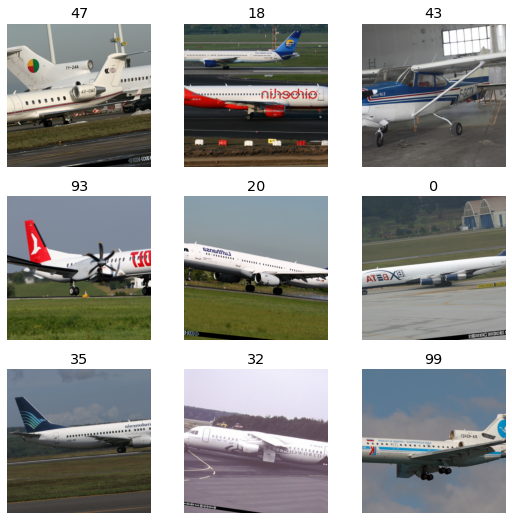

In [15]:
data0.show_batch()

In [16]:
import damped_losses as losses
loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [17]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= mae_aircrafts_asym_0.1_baseline


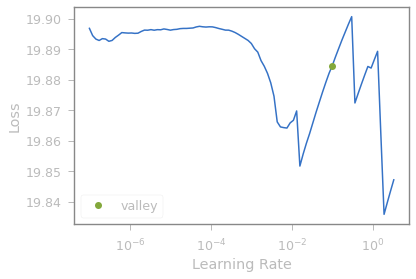

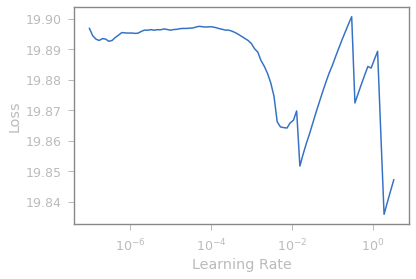

In [18]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,18.824450,18.357965,0.088522,01:49
1,18.583427,19.225842,0.039010,01:48
2,19.363199,19.750422,0.012003,01:49
3,19.809046,19.714430,0.014254,01:49
4,19.806038,19.854235,0.008252,01:49
5,19.758696,19.829084,0.008252,01:49
6,19.773712,19.744591,0.012753,01:49
7,19.724920,19.849133,0.007502,01:49
8,19.790510,19.821863,0.008252,01:49
9,19.685135,19.810741,0.009002,01:49


Better model found at epoch 0 with accuracy value: 0.08852212876081467.


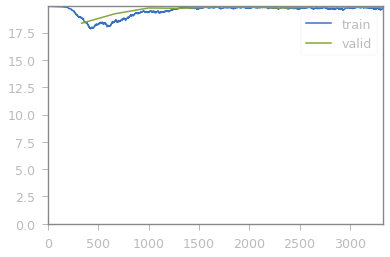

In [19]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,17.183611,17.223469,0.156039,01:49
1,15.635818,15.829040,0.239310,01:49
2,14.078343,14.464051,0.280570,01:49
3,12.391765,11.968271,0.418605,01:49
4,11.043219,11.352814,0.449362,01:49
5,10.511403,10.996783,0.463616,01:49
6,10.000964,11.082753,0.452363,01:49
7,10.169949,11.234020,0.453113,01:49
8,10.401429,12.962555,0.360840,01:49
9,10.123149,11.423989,0.444111,01:49


Better model found at epoch 0 with accuracy value: 0.1560390144586563.


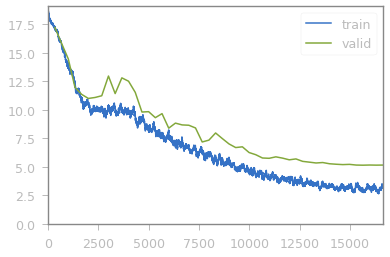

Better model found at epoch 1 with accuracy value: 0.23930983245372772.
Better model found at epoch 2 with accuracy value: 0.2805701494216919.
Better model found at epoch 3 with accuracy value: 0.41860464215278625.
Better model found at epoch 4 with accuracy value: 0.4493623375892639.
Better model found at epoch 5 with accuracy value: 0.46361589431762695.
Better model found at epoch 13 with accuracy value: 0.5236309170722961.
Better model found at epoch 15 with accuracy value: 0.5416353940963745.
Better model found at epoch 17 with accuracy value: 0.5851463079452515.
Better model found at epoch 22 with accuracy value: 0.646661639213562.
Better model found at epoch 26 with accuracy value: 0.6556639075279236.
Better model found at epoch 27 with accuracy value: 0.6684170961380005.
Better model found at epoch 29 with accuracy value: 0.6931732892990112.
Better model found at epoch 30 with accuracy value: 0.7014253735542297.
Better model found at epoch 31 with accuracy value: 0.7149287462234

In [21]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [22]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.8242)


In [23]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.8305)


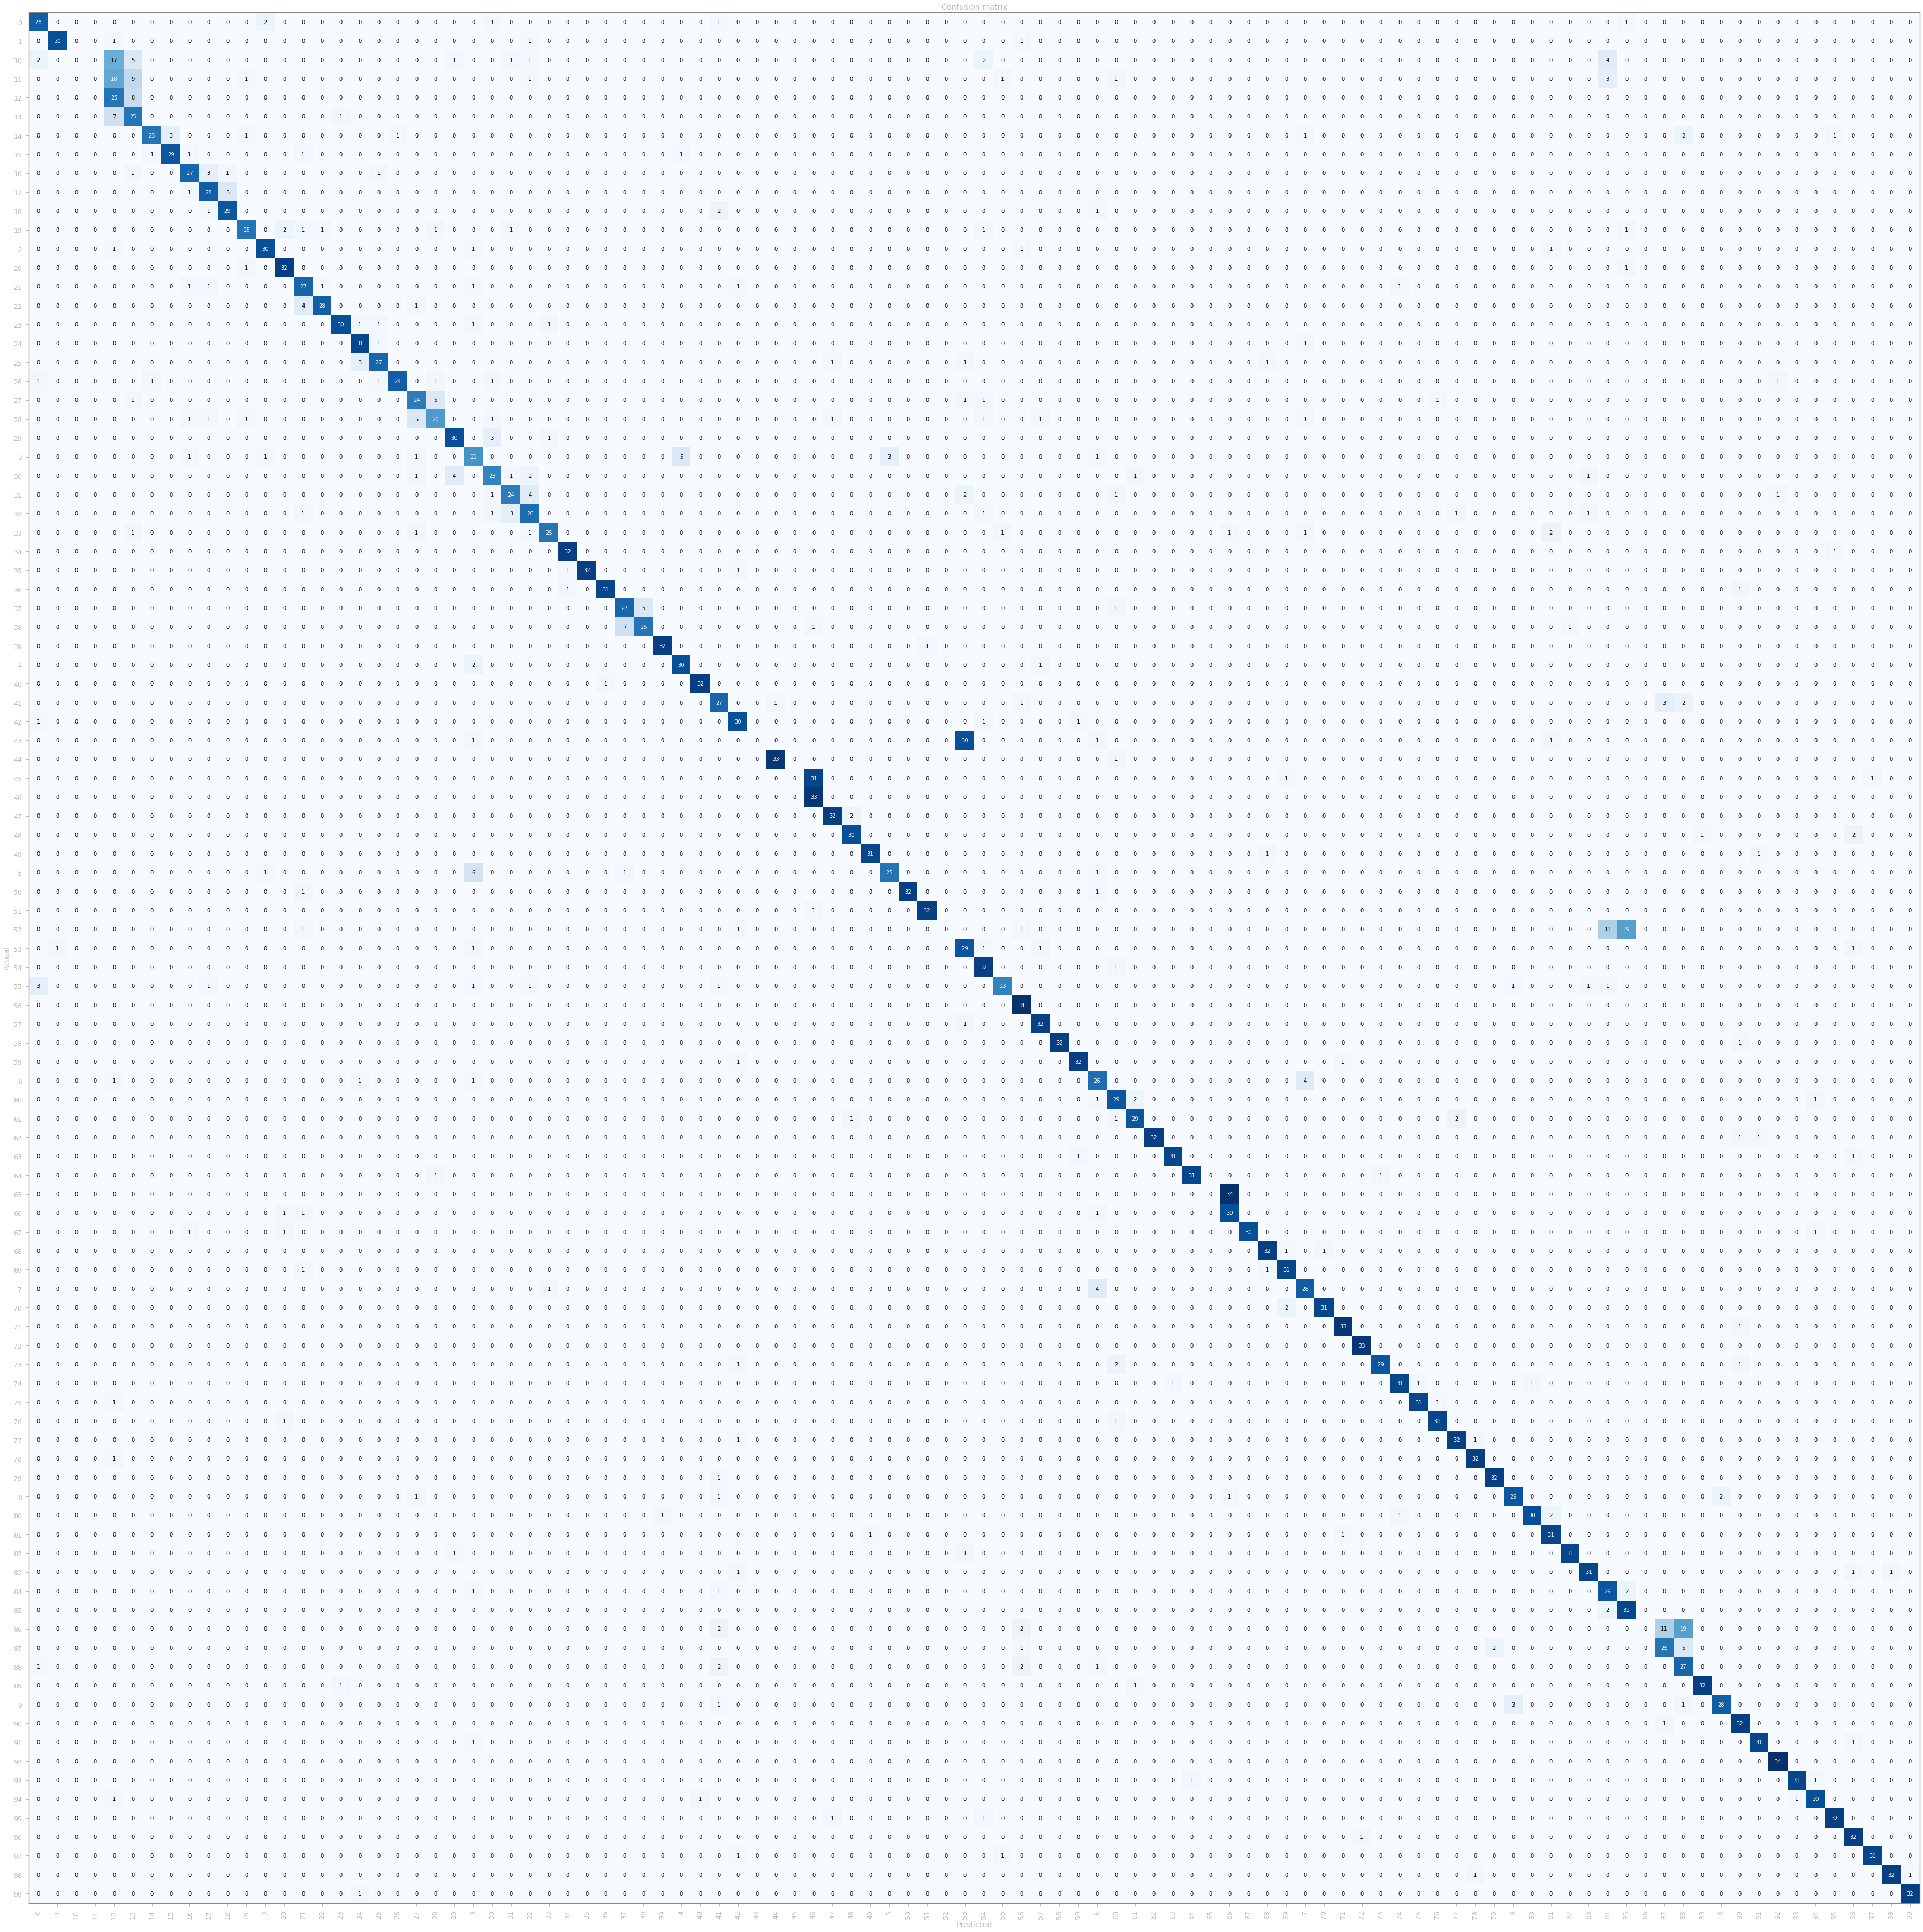

In [24]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [25]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [26]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/mae_aircrafts_asym_0.1_baseline.pth'

In [27]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
        #print(f'Frequency of class {cl}: {class_freq[cl]} ')
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


epoch,train_loss,valid_loss,accuracy,time
0,3.343994,3.610878,0.819486,01:50


Better model found at epoch 0 with accuracy value: 0.8194863796234131.


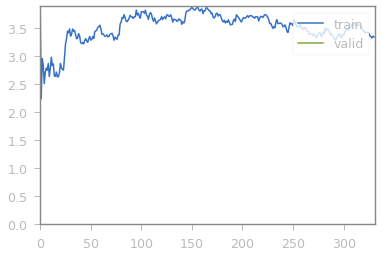

************Round:  0
TTA Accuracy:0.8322831988334656
cycle 0 Error Rate is [{0: (0.6749662516874144, 16.771680116653442)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 32 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6590


epoch,train_loss,valid_loss,accuracy,time
0,3.659832,3.511826,0.825493,01:49


Better model found at epoch 0 with accuracy value: 0.8254931569099426.


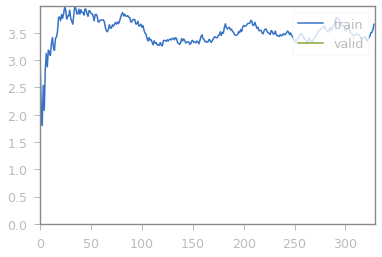

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 37 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6553


epoch,train_loss,valid_loss,accuracy,time
0,3.311440,3.526892,0.823664,01:49


Better model found at epoch 0 with accuracy value: 0.823664128780365.


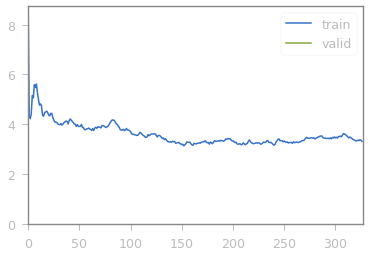

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 35 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6518


epoch,train_loss,valid_loss,accuracy,time
0,3.544944,3.227103,0.838833,01:47


Better model found at epoch 0 with accuracy value: 0.8388334512710571.


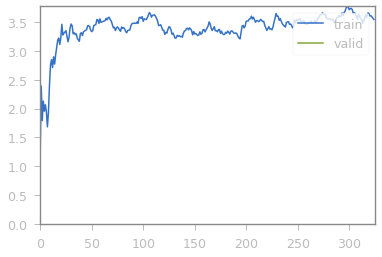

************Round:  3
TTA Accuracy:0.8352835178375244
cycle 0 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 33 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6485


epoch,train_loss,valid_loss,accuracy,time
0,3.654059,3.250211,0.838859,01:47


Better model found at epoch 0 with accuracy value: 0.8388589024543762.


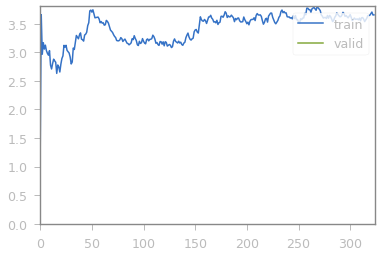

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 26 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6459


epoch,train_loss,valid_loss,accuracy,time
0,3.289008,3.116081,0.845856,01:46


Better model found at epoch 0 with accuracy value: 0.8458559513092041.


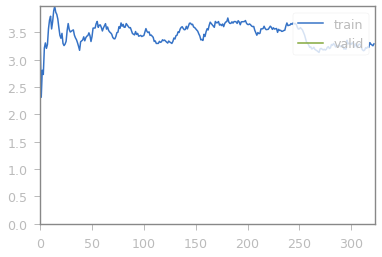

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 24 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6435


epoch,train_loss,valid_loss,accuracy,time
0,3.420448,3.236385,0.839161,01:45


Better model found at epoch 0 with accuracy value: 0.8391608595848083.


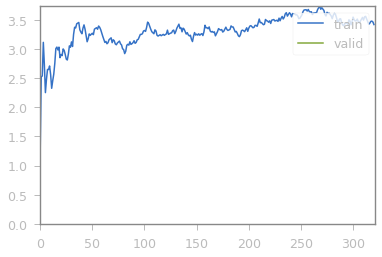

************Round:  6
TTA Accuracy:0.8337833881378174
cycle 0 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 19 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6416


epoch,train_loss,valid_loss,accuracy,time
0,3.531520,3.046448,0.847233,01:46


Better model found at epoch 0 with accuracy value: 0.8472330570220947.


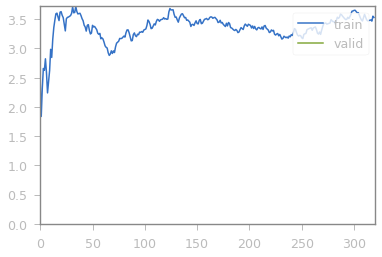

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 22 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6394


epoch,train_loss,valid_loss,accuracy,time
0,3.320243,3.167445,0.841941,01:44


Better model found at epoch 0 with accuracy value: 0.8419405221939087.


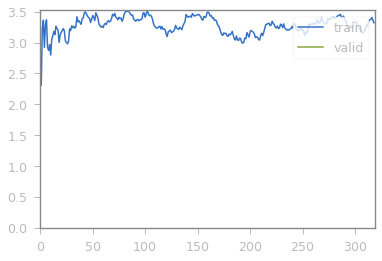

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 31
Min probability = 0.4164179104477612
Dropped 22 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6372


epoch,train_loss,valid_loss,accuracy,time
0,3.296340,3.207546,0.839874,01:46


Better model found at epoch 0 with accuracy value: 0.8398743867874146.


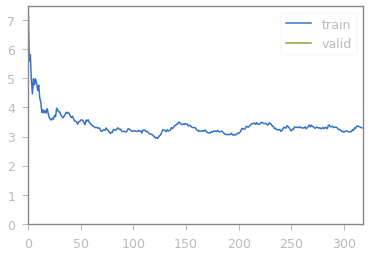

************Round:  9
TTA Accuracy:0.8352835178375244
cycle 0 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 30
Min probability = 0.40298507462686567
Dropped 27 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6345


epoch,train_loss,valid_loss,accuracy,time
0,3.087592,3.352687,0.832151,01:44


Better model found at epoch 0 with accuracy value: 0.8321512937545776.


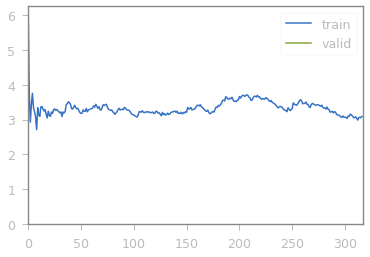

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 29
Min probability = 0.3895522388059701
Dropped 19 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6326


epoch,train_loss,valid_loss,accuracy,time
0,3.065865,3.159403,0.843478,01:44


Better model found at epoch 0 with accuracy value: 0.843478262424469.


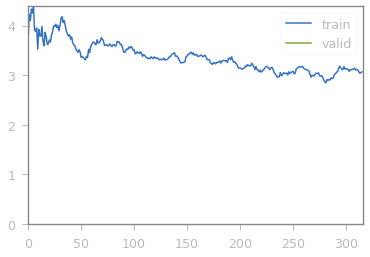

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 19 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6307


epoch,train_loss,valid_loss,accuracy,time
0,3.472971,3.373956,0.831879,01:46


Better model found at epoch 0 with accuracy value: 0.8318794369697571.


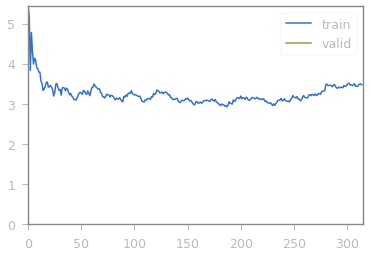

************Round:  12
TTA Accuracy:0.8376837968826294
cycle 0 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 9 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6298


epoch,train_loss,valid_loss,accuracy,time
0,3.619545,2.963121,0.853058,01:43


Better model found at epoch 0 with accuracy value: 0.8530579805374146.


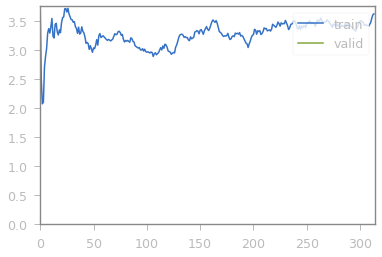

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 23
Min probability = 0.30895522388059704
Dropped 13 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6285


epoch,train_loss,valid_loss,accuracy,time
0,3.270942,2.936256,0.853620,01:43


Better model found at epoch 0 with accuracy value: 0.8536197543144226.


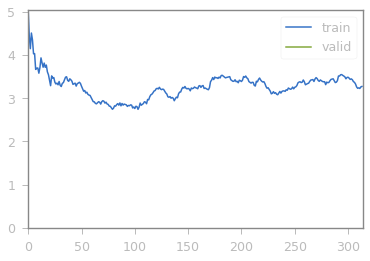

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,3.300721,3.020319,0.850453,01:48


Better model found at epoch 0 with accuracy value: 0.8504531979560852.


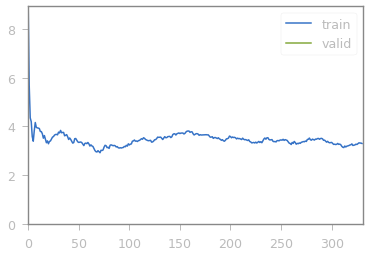

************Round:  0
TTA Accuracy:0.8403840661048889
cycle 1 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 36 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6587


epoch,train_loss,valid_loss,accuracy,time
0,3.554135,3.044202,0.848899,01:47


Better model found at epoch 0 with accuracy value: 0.8488990068435669.


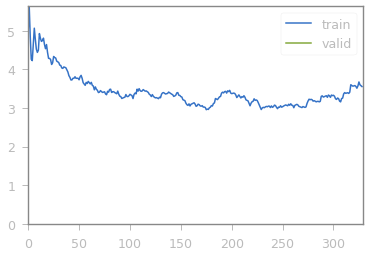

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 29 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6558


epoch,train_loss,valid_loss,accuracy,time
0,3.630552,2.844440,0.859649,01:49


Better model found at epoch 0 with accuracy value: 0.859649121761322.


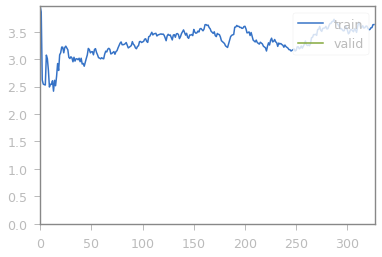

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 29 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6529


epoch,train_loss,valid_loss,accuracy,time
0,3.417204,3.147712,0.842146,01:47


Better model found at epoch 0 with accuracy value: 0.8421456217765808.


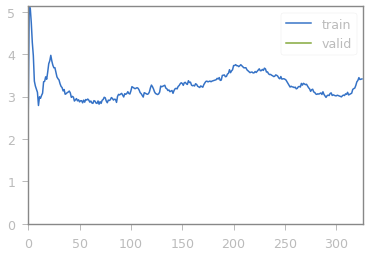

************Round:  3
TTA Accuracy:0.8388838768005371
cycle 1 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 24 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6505


epoch,train_loss,valid_loss,accuracy,time
0,3.422396,3.068294,0.846272,01:46


Better model found at epoch 0 with accuracy value: 0.8462721109390259.


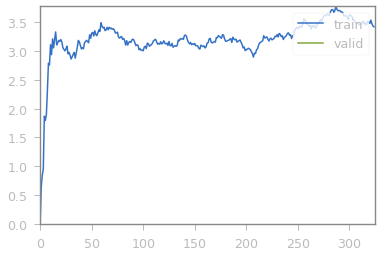

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 29 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6476


epoch,train_loss,valid_loss,accuracy,time
0,3.157084,2.946128,0.854054,01:46


Better model found at epoch 0 with accuracy value: 0.8540540337562561.


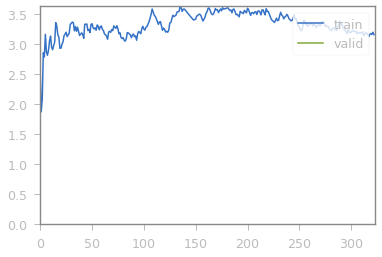

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 39
Min probability = 0.5238805970149254
Dropped 28 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6448


epoch,train_loss,valid_loss,accuracy,time
0,3.099694,3.137145,0.843289,01:45


Better model found at epoch 0 with accuracy value: 0.8432893753051758.


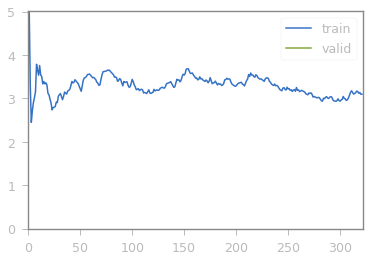

************Round:  6
TTA Accuracy:0.8394839763641357
cycle 1 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 30 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6418


epoch,train_loss,valid_loss,accuracy,time
0,3.292964,2.950881,0.851910,01:45


Better model found at epoch 0 with accuracy value: 0.8519095778465271.


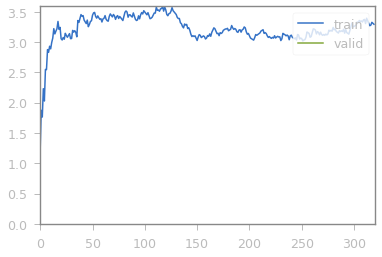

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 30
Min probability = 0.40298507462686567
Dropped 29 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6389


epoch,train_loss,valid_loss,accuracy,time
0,3.183599,2.789641,0.861394,01:44


Better model found at epoch 0 with accuracy value: 0.8613938689231873.


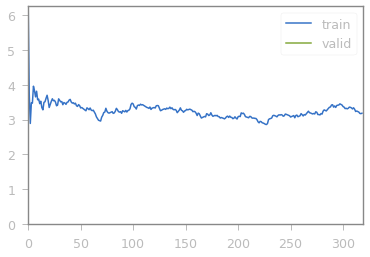

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 29
Min probability = 0.3895522388059701
Dropped 20 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6369


epoch,train_loss,valid_loss,accuracy,time
0,2.933037,2.924404,0.853103,01:44


Better model found at epoch 0 with accuracy value: 0.8531029224395752.


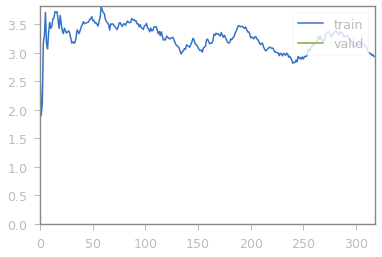

************Round:  9
TTA Accuracy:0.8379837870597839
cycle 1 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 27
Min probability = 0.36268656716417913
Dropped 18 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6351


epoch,train_loss,valid_loss,accuracy,time
0,3.463013,2.785350,0.861417,01:44


Better model found at epoch 0 with accuracy value: 0.861417293548584.


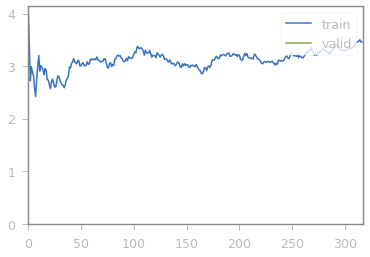

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 18 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6333


epoch,train_loss,valid_loss,accuracy,time
0,3.084657,2.949436,0.853081,01:45


Better model found at epoch 0 with accuracy value: 0.8530805706977844.


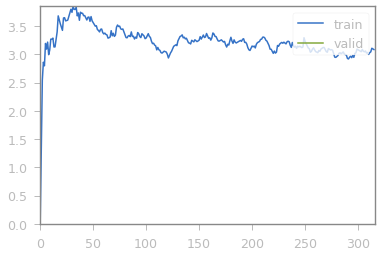

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 14 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6319


epoch,train_loss,valid_loss,accuracy,time
0,3.333589,2.890264,0.855899,01:43


Better model found at epoch 0 with accuracy value: 0.8558986783027649.


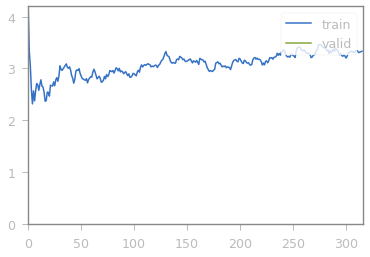

************Round:  12
TTA Accuracy:0.8385838866233826
cycle 1 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 23
Min probability = 0.30895522388059704
Dropped 18 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6301


epoch,train_loss,valid_loss,accuracy,time
0,2.883934,2.699923,0.865873,01:43


Better model found at epoch 0 with accuracy value: 0.8658730387687683.


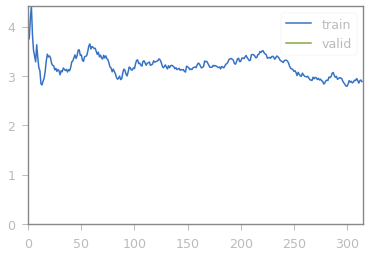

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 22
Min probability = 0.2955223880597015
Dropped 13 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6288


epoch,train_loss,valid_loss,accuracy,time
0,3.235195,2.992279,0.849642,01:43


Better model found at epoch 0 with accuracy value: 0.8496419787406921.


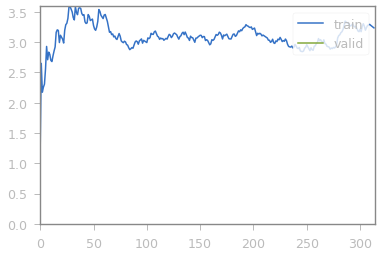

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 47 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6620


epoch,train_loss,valid_loss,accuracy,time
0,3.081516,2.955261,0.851964,01:48


Better model found at epoch 0 with accuracy value: 0.8519637584686279.


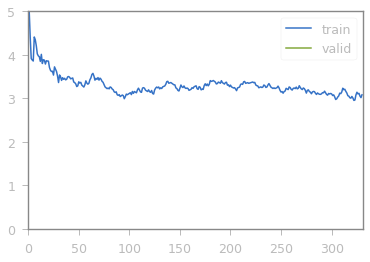

************Round:  0
TTA Accuracy:0.8397839665412903
cycle 2 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 42 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6578


epoch,train_loss,valid_loss,accuracy,time
0,3.174781,3.078269,0.846388,01:47


Better model found at epoch 0 with accuracy value: 0.8463878035545349.


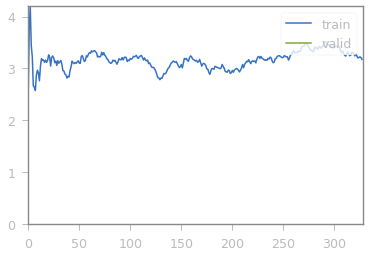

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 33 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6545


epoch,train_loss,valid_loss,accuracy,time
0,2.921309,2.874095,0.856379,01:47


Better model found at epoch 0 with accuracy value: 0.8563789129257202.


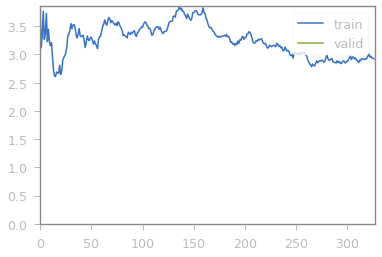

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 35 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6510


epoch,train_loss,valid_loss,accuracy,time
0,3.018329,3.264174,0.837174,01:46


Better model found at epoch 0 with accuracy value: 0.837173581123352.


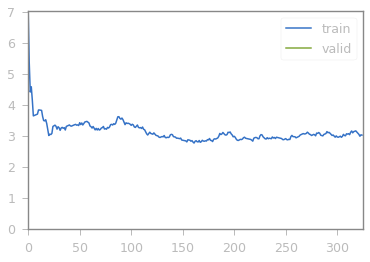

************Round:  3
TTA Accuracy:0.8445844650268555
cycle 2 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097), 33: (2.354882255887203, 15.541553497314453)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 39
Min probability = 0.5238805970149254
Dropped 22 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6488


epoch,train_loss,valid_loss,accuracy,time
0,3.399789,2.760335,0.862760,01:46


Better model found at epoch 0 with accuracy value: 0.8627601861953735.


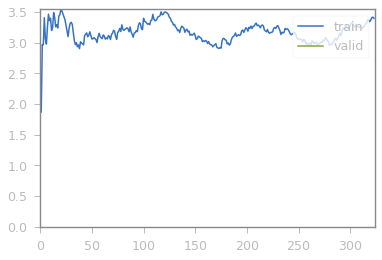

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 27 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6461


epoch,train_loss,valid_loss,accuracy,time
0,3.012088,2.872837,0.856811,01:46


Better model found at epoch 0 with accuracy value: 0.8568111658096313.


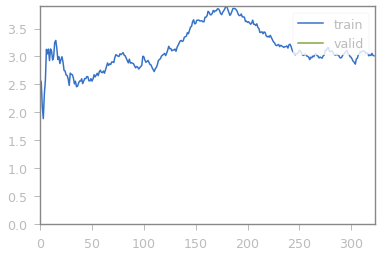

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 22 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6439


epoch,train_loss,valid_loss,accuracy,time
0,2.853260,3.005323,0.850039,01:46


Better model found at epoch 0 with accuracy value: 0.8500388264656067.


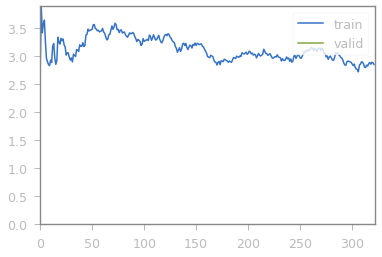

************Round:  6
TTA Accuracy:0.8385838866233826
cycle 2 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097), 33: (2.354882255887203, 15.541553497314453), 36: (3.4198290085495686, 16.141611337661743)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 25 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6414


epoch,train_loss,valid_loss,accuracy,time
0,3.055237,2.838852,0.858814,01:44


Better model found at epoch 0 with accuracy value: 0.8588143587112427.


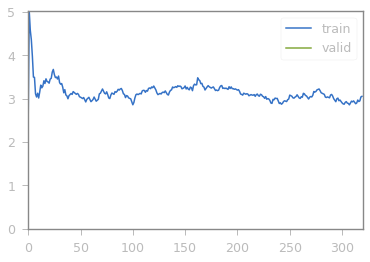

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 34
Min probability = 0.4567164179104478
Dropped 16 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6398


epoch,train_loss,valid_loss,accuracy,time
0,3.268583,2.804802,0.860047,01:45


Better model found at epoch 0 with accuracy value: 0.860046923160553.


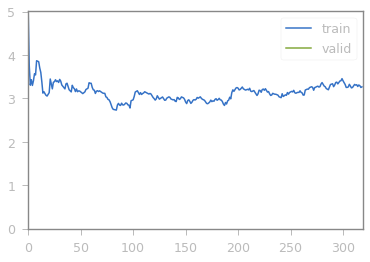

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 32
Min probability = 0.4298507462686567
Dropped 15 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6383


epoch,train_loss,valid_loss,accuracy,time
0,3.005468,3.084582,0.846395,01:45


Better model found at epoch 0 with accuracy value: 0.846394956111908.


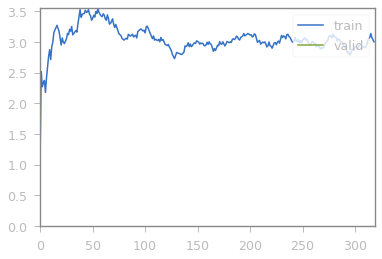

************Round:  9
TTA Accuracy:0.8436843752861023
cycle 2 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097), 33: (2.354882255887203, 15.541553497314453), 36: (3.4198290085495686, 16.141611337661743), 39: (4.259787010649463, 15.63156247138977)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 31
Min probability = 0.4164179104477612
Dropped 21 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6362


epoch,train_loss,valid_loss,accuracy,time
0,3.113399,2.993633,0.850629,01:46


Better model found at epoch 0 with accuracy value: 0.8506289124488831.


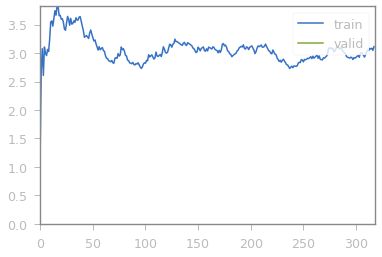

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 30
Min probability = 0.40298507462686567
Dropped 25 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6337


epoch,train_loss,valid_loss,accuracy,time
0,2.863084,3.237631,0.838200,01:44


Better model found at epoch 0 with accuracy value: 0.8382004499435425.


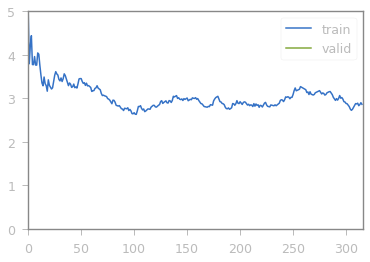

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 14 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6323


epoch,train_loss,valid_loss,accuracy,time
0,3.061363,2.848859,0.858386,01:44


Better model found at epoch 0 with accuracy value: 0.8583860993385315.


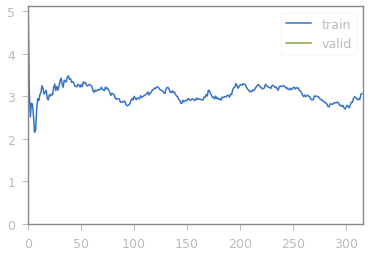

************Round:  12
TTA Accuracy:0.8421842455863953
cycle 2 Error Rate is [{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097), 33: (2.354882255887203, 15.541553497314453), 36: (3.4198290085495686, 16.141611337661743), 39: (4.259787010649463, 15.63156247138977), 42: (5.159742012899359, 15.781575441360474)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 16 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6307


epoch,train_loss,valid_loss,accuracy,time
0,2.945174,2.842086,0.858049,01:43


Better model found at epoch 0 with accuracy value: 0.8580491542816162.


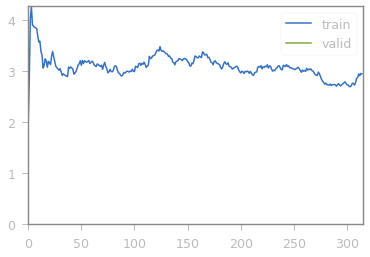

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 21
Min probability = 0.282089552238806
Dropped 16 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6291


epoch,train_loss,valid_loss,accuracy,time
0,2.846013,2.923661,0.853736,01:43


Better model found at epoch 0 with accuracy value: 0.8537361025810242.


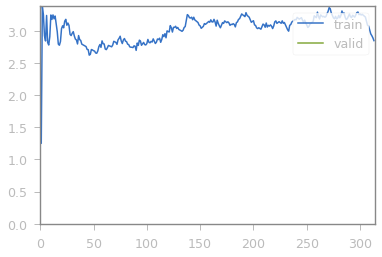

In [28]:
drop_idxx = []
los = []
top_losses = []
n_training_series = 15  # orginally it is 15, but for testing purpose we are using with 1 to check the scheme with custom function.
min_epochs = 1
min_prob=0.5
max_prob=0.9
delta_epochs_per_serie =  0
min_lr = 1e-4
kappa_lr = 1 
k_samples = 0
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
cleaning_cycles = 3 
delta_max = 0.25
accs = []
deltas = []
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
#         print(f'delta = {delta}')
        loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        k_samples = 50
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
           
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [29]:
# err = {}
print(err)

{0: (0.6749662516874144, 16.771680116653442), 3: (2.2348882555872196, 16.47164821624756), 6: (3.4798260086995603, 16.62166118621826), 9: (4.424778761061942, 16.47164821624756), 12: (5.399730013499326, 16.23162031173706), 15: (0.6599670016499193, 15.961593389511108), 18: (2.0698965051747398, 16.11161231994629), 21: (3.28483575821209, 16.051602363586426), 24: (4.469776511174439, 16.201621294021606), 27: (5.2197390130493515, 16.141611337661743), 30: (0.7049647517624158, 16.02160334587097), 33: (2.354882255887203, 15.541553497314453), 36: (3.4198290085495686, 16.141611337661743), 39: (4.259787010649463, 15.63156247138977), 42: (5.159742012899359, 15.781575441360474)}


In [30]:
for i in range(len(accs)):
    print(f'acc:{accs[i]}, delta:{deltas[i]}')

acc:0.8322831988334656, delta:0.05197792270443983
acc:0.8352835178375244, delta:0.18578620636934853
acc:0.8337833881378174, delta:0.24863047384206832
acc:0.8352835178375244, delta:0.21650635094610968
acc:0.8376837968826294, delta:0.10168416076895001
acc:0.8403840661048889, delta:0.05197792270443983
acc:0.8388838768005371, delta:0.18578620636934853
acc:0.8394839763641357, delta:0.24863047384206832
acc:0.8379837870597839, delta:0.21650635094610968
acc:0.8385838866233826, delta:0.10168416076895001
acc:0.8397839665412903, delta:0.05197792270443983
acc:0.8445844650268555, delta:0.18578620636934853
acc:0.8385838866233826, delta:0.24863047384206832
acc:0.8436843752861023, delta:0.21650635094610968
acc:0.8421842455863953, delta:0.10168416076895001


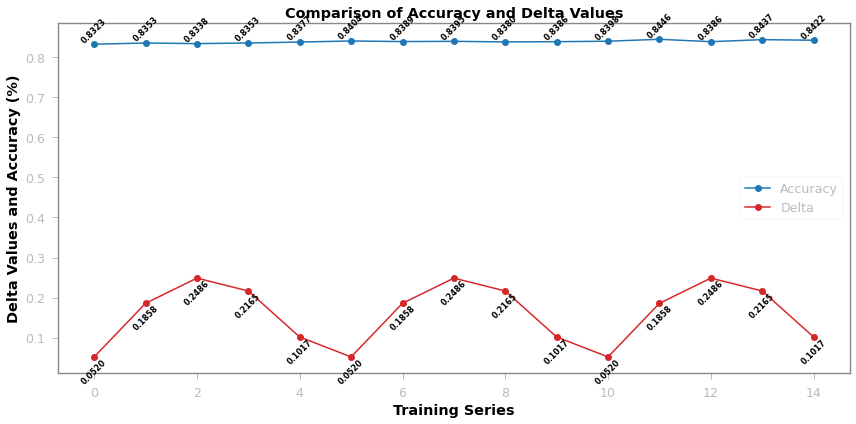

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 47 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6620


epoch,train_loss,valid_loss,accuracy,time
0,2.776624,2.875009,0.857251,01:48


Better model found at epoch 0 with accuracy value: 0.8572507500648499.


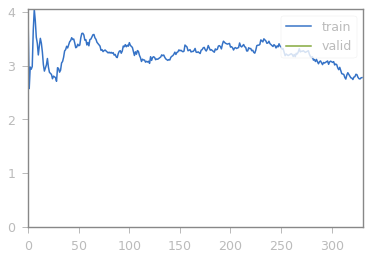

************Round:  0
TTA Accuracy:0.8436843752861023
cycle 0 Error Rate is [{0: (0.7049647517624158, 15.63156247138977)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 36 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6584


epoch,train_loss,valid_loss,accuracy,time
0,3.087386,2.840273,0.858663,01:49


Better model found at epoch 0 with accuracy value: 0.8586626052856445.


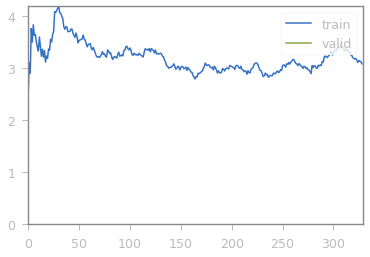

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 37 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6547


epoch,train_loss,valid_loss,accuracy,time
0,3.026551,2.938583,0.853323,01:47


Better model found at epoch 0 with accuracy value: 0.8533231616020203.


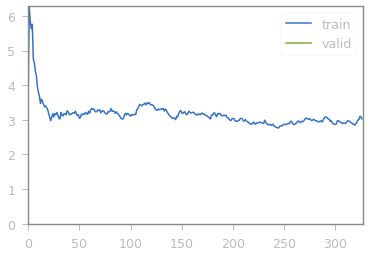

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 33 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6514


epoch,train_loss,valid_loss,accuracy,time
0,3.129575,3.334170,0.833333,01:47


Better model found at epoch 0 with accuracy value: 0.8333333134651184.


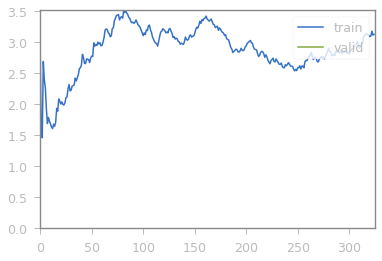

************Round:  3
TTA Accuracy:0.8430843353271484
cycle 0 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 30 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6484


epoch,train_loss,valid_loss,accuracy,time
0,3.006678,2.930510,0.853395,01:46


Better model found at epoch 0 with accuracy value: 0.8533950448036194.


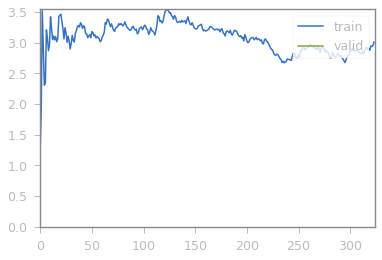

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 25 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6459


epoch,train_loss,valid_loss,accuracy,time
0,3.010544,2.930481,0.853602,01:46


Better model found at epoch 0 with accuracy value: 0.85360187292099.


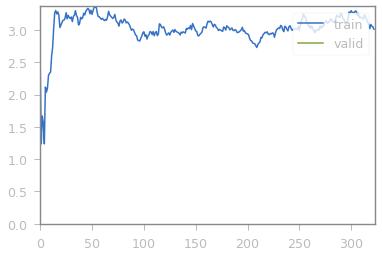

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 24 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6435


epoch,train_loss,valid_loss,accuracy,time
0,3.037472,2.773219,0.861694,01:46


Better model found at epoch 0 with accuracy value: 0.8616938591003418.


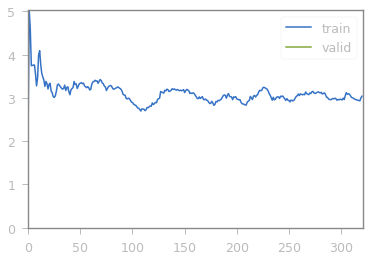

************Round:  6
TTA Accuracy:0.841884195804596
cycle 0 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 37
Min probability = 0.49701492537313435
Dropped 27 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6408


epoch,train_loss,valid_loss,accuracy,time
0,2.864494,2.906212,0.854801,01:46


Better model found at epoch 0 with accuracy value: 0.8548009395599365.


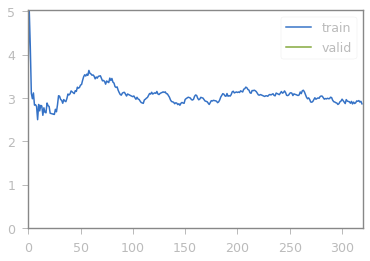

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 31 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6377


epoch,train_loss,valid_loss,accuracy,time
0,2.979887,2.783877,0.860392,01:45


Better model found at epoch 0 with accuracy value: 0.860392153263092.


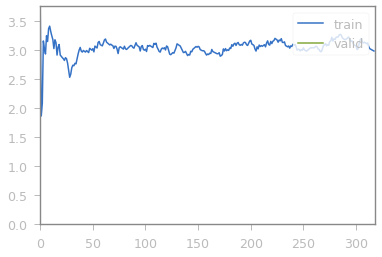

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 31
Min probability = 0.4164179104477612
Dropped 16 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6361


epoch,train_loss,valid_loss,accuracy,time
0,2.922724,3.125064,0.844340,01:44


Better model found at epoch 0 with accuracy value: 0.8443396091461182.


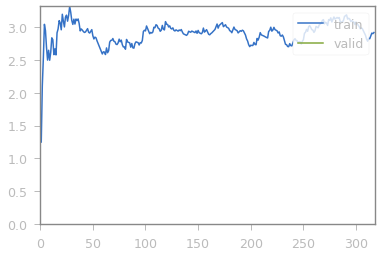

************Round:  9
TTA Accuracy:0.8412841558456421
cycle 0 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 17 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6344


epoch,train_loss,valid_loss,accuracy,time
0,3.136326,2.506004,0.874606,01:45


Better model found at epoch 0 with accuracy value: 0.874605655670166.


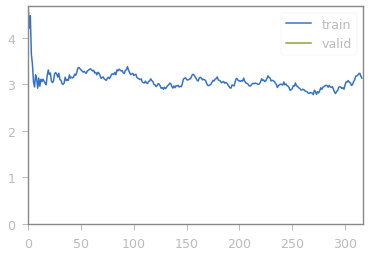

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 26
Min probability = 0.3492537313432836
Dropped 15 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6329


epoch,train_loss,valid_loss,accuracy,time
0,3.313911,2.896826,0.855336,01:44


Better model found at epoch 0 with accuracy value: 0.8553359508514404.


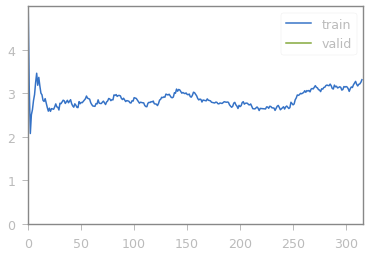

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 13 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6316


epoch,train_loss,valid_loss,accuracy,time
0,3.071708,2.986383,0.850356,01:43


Better model found at epoch 0 with accuracy value: 0.8503562808036804.


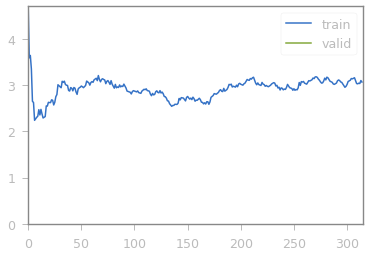

************Round:  12
TTA Accuracy:0.8400840163230896
cycle 0 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 18 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6298


epoch,train_loss,valid_loss,accuracy,time
0,3.052016,2.853592,0.857029,01:43


Better model found at epoch 0 with accuracy value: 0.857029378414154.


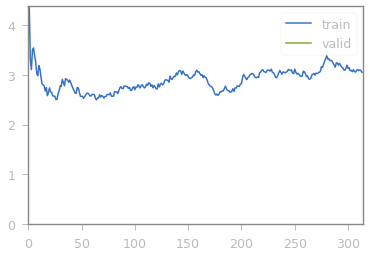

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 24
Min probability = 0.32238805970149254
Dropped 15 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6283


epoch,train_loss,valid_loss,accuracy,time
0,2.796767,2.731846,0.863057,01:43


Better model found at epoch 0 with accuracy value: 0.8630573153495789.


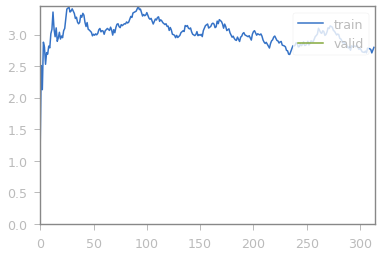

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 44 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6623


epoch,train_loss,valid_loss,accuracy,time
0,2.794343,3.008497,0.849698,01:48


Better model found at epoch 0 with accuracy value: 0.8496978878974915.


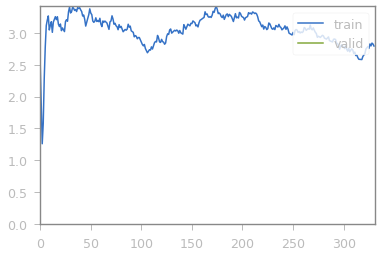

************Round:  0
TTA Accuracy:0.8397839665412903
cycle 1 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 35 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6588


epoch,train_loss,valid_loss,accuracy,time
0,3.070051,3.029694,0.848899,01:48


Better model found at epoch 0 with accuracy value: 0.8488990068435669.


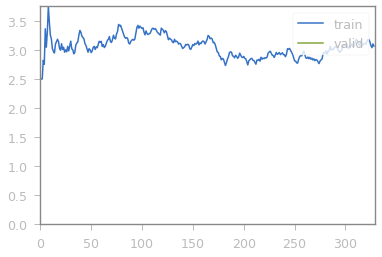

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 36 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6552


epoch,train_loss,valid_loss,accuracy,time
0,2.984332,2.758718,0.862595,01:47


Better model found at epoch 0 with accuracy value: 0.8625954389572144.


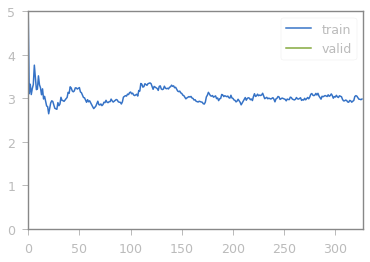

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 23 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6529


epoch,train_loss,valid_loss,accuracy,time
0,3.070195,2.937745,0.853640,01:47


Better model found at epoch 0 with accuracy value: 0.8536398410797119.


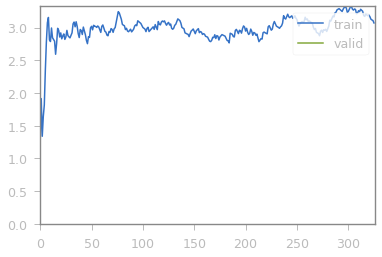

************Round:  3
TTA Accuracy:0.8367837071418762
cycle 1 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 30 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,2.977315,2.695668,0.866051,01:46


Better model found at epoch 0 with accuracy value: 0.8660507798194885.


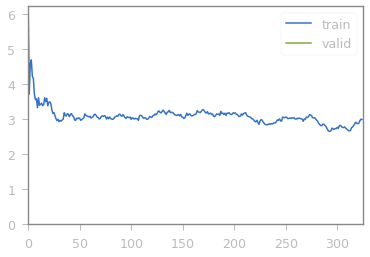

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 27 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6472


epoch,train_loss,valid_loss,accuracy,time
0,2.889454,2.885169,0.856260,01:46


Better model found at epoch 0 with accuracy value: 0.8562596440315247.


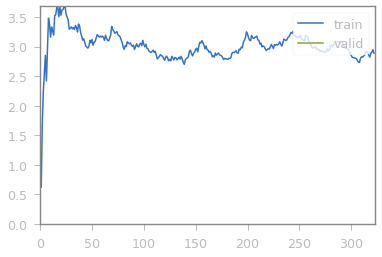

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 23 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6449


epoch,train_loss,valid_loss,accuracy,time
0,3.187346,3.111838,0.844065,01:45


Better model found at epoch 0 with accuracy value: 0.8440651893615723.


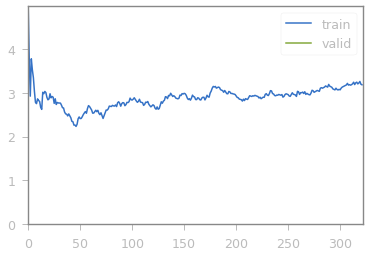

************Round:  6
TTA Accuracy:0.8421842455863953
cycle 1 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 32 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6417


epoch,train_loss,valid_loss,accuracy,time
0,2.689817,2.936511,0.853468,01:45


Better model found at epoch 0 with accuracy value: 0.8534684181213379.


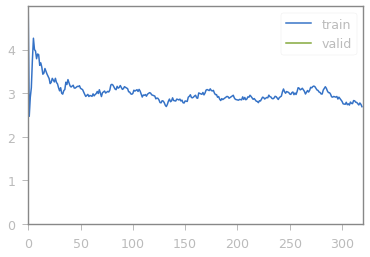

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 28 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6389


epoch,train_loss,valid_loss,accuracy,time
0,3.002908,2.985422,0.850431,01:44


Better model found at epoch 0 with accuracy value: 0.8504306674003601.


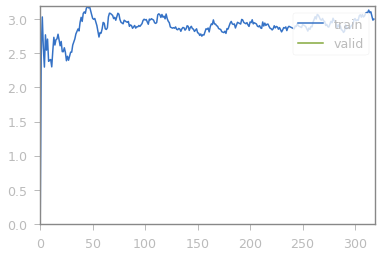

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 32
Min probability = 0.4298507462686567
Dropped 19 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6370


epoch,train_loss,valid_loss,accuracy,time
0,2.748914,3.044300,0.847724,01:44


Better model found at epoch 0 with accuracy value: 0.8477237224578857.


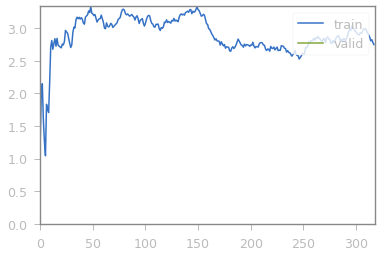

************Round:  9
TTA Accuracy:0.8385838866233826
cycle 1 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 31
Min probability = 0.4164179104477612
Dropped 18 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6352


epoch,train_loss,valid_loss,accuracy,time
0,3.221088,2.815088,0.859843,01:44


Better model found at epoch 0 with accuracy value: 0.8598425388336182.


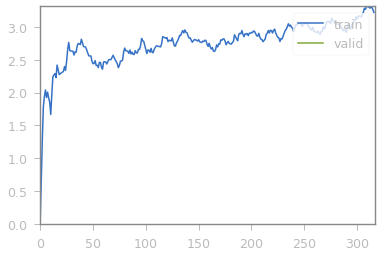

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 29
Min probability = 0.3895522388059701
Dropped 14 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6338


epoch,train_loss,valid_loss,accuracy,time
0,2.798314,2.837015,0.858721,01:44


Better model found at epoch 0 with accuracy value: 0.8587213754653931.


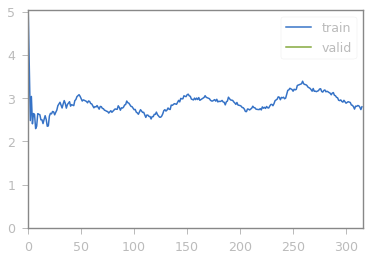

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 29
Min probability = 0.3895522388059701
Dropped 19 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6319


epoch,train_loss,valid_loss,accuracy,time
0,3.166784,2.991812,0.850356,01:44


Better model found at epoch 0 with accuracy value: 0.8503562808036804.


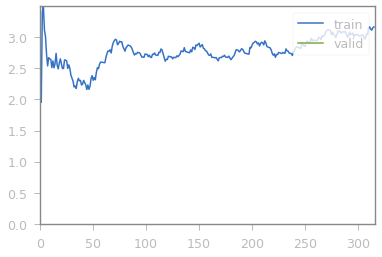

************Round:  12
TTA Accuracy:0.8436843752861023
cycle 1 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 17 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6302


epoch,train_loss,valid_loss,accuracy,time
0,2.801980,3.166178,0.841270,01:43


Better model found at epoch 0 with accuracy value: 0.841269850730896.


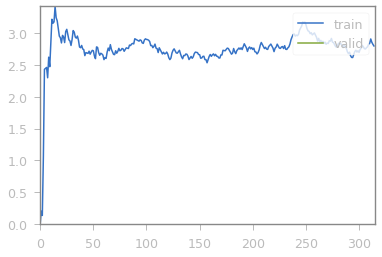

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 17 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6285


epoch,train_loss,valid_loss,accuracy,time
0,3.006559,2.426351,0.878282,01:43


Better model found at epoch 0 with accuracy value: 0.8782815933227539.


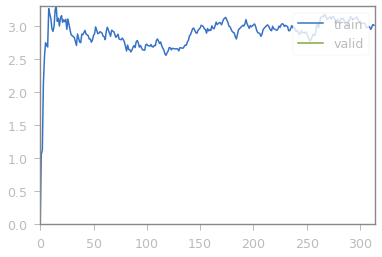

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


epoch,train_loss,valid_loss,accuracy,time
0,2.615793,2.924114,0.854230,01:48


Better model found at epoch 0 with accuracy value: 0.8542296290397644.


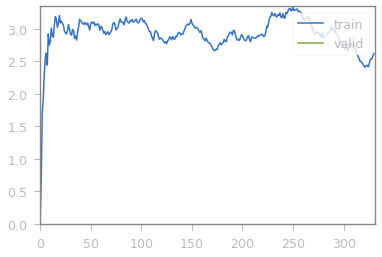

************Round:  0
TTA Accuracy:0.8430843353271484
cycle 2 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977), 30: (0.6449677516124241, 15.691566467285156)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 40 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6584


epoch,train_loss,valid_loss,accuracy,time
0,2.977496,2.751875,0.862462,01:47


Better model found at epoch 0 with accuracy value: 0.8624619841575623.


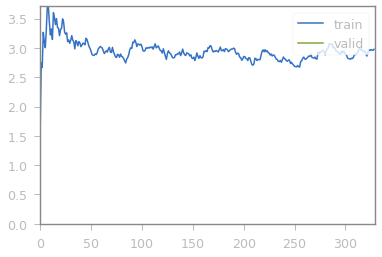

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 38 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6546


epoch,train_loss,valid_loss,accuracy,time
0,2.899705,2.624830,0.870130,01:47


Better model found at epoch 0 with accuracy value: 0.8701298832893372.


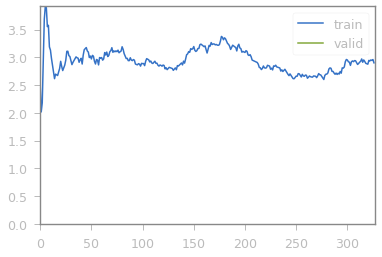

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 33 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6513


epoch,train_loss,valid_loss,accuracy,time
0,2.933184,2.719981,0.864055,01:46


Better model found at epoch 0 with accuracy value: 0.8640552759170532.


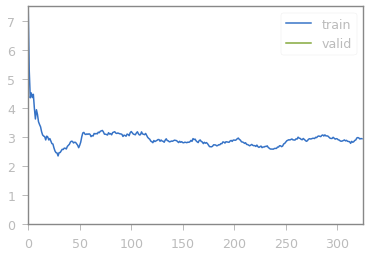

************Round:  3
TTA Accuracy:0.841884195804596
cycle 2 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977), 30: (0.6449677516124241, 15.691566467285156), 33: (2.3098845057747064, 15.811580419540405)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 30 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6483


epoch,train_loss,valid_loss,accuracy,time
0,2.822613,2.678154,0.866512,01:46


Better model found at epoch 0 with accuracy value: 0.8665123581886292.


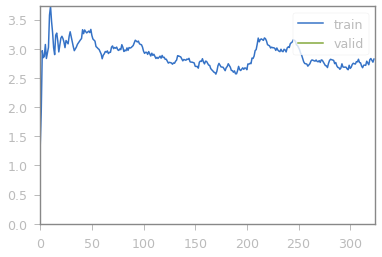

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 26 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6457


epoch,train_loss,valid_loss,accuracy,time
0,2.820735,2.862777,0.856700,01:45


Better model found at epoch 0 with accuracy value: 0.8567002415657043.


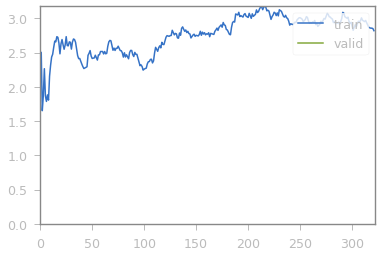

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 22 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6435


epoch,train_loss,valid_loss,accuracy,time
0,2.772176,2.797261,0.860140,01:45


Better model found at epoch 0 with accuracy value: 0.8601398468017578.


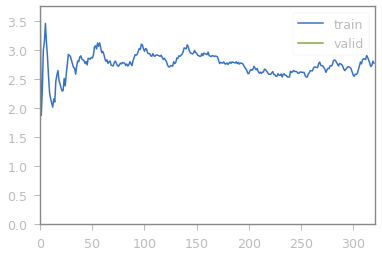

************Round:  6
TTA Accuracy:0.8454845547676086
cycle 2 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977), 30: (0.6449677516124241, 15.691566467285156), 33: (2.3098845057747064, 15.811580419540405), 36: (3.4798260086995603, 15.451544523239136)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 26 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6409


epoch,train_loss,valid_loss,accuracy,time
0,2.706356,2.819423,0.858704,01:45


Better model found at epoch 0 with accuracy value: 0.858704149723053.


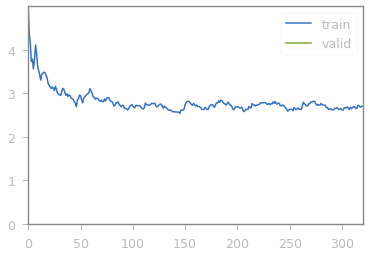

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 34
Min probability = 0.4567164179104478
Dropped 19 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6390


epoch,train_loss,valid_loss,accuracy,time
0,2.484500,2.621726,0.869327,01:44


Better model found at epoch 0 with accuracy value: 0.8693270683288574.


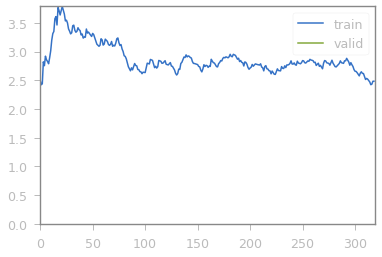

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 33
Min probability = 0.4432835820895522
Dropped 18 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6372


epoch,train_loss,valid_loss,accuracy,time
0,2.561295,2.784147,0.860283,01:44


Better model found at epoch 0 with accuracy value: 0.8602825999259949.


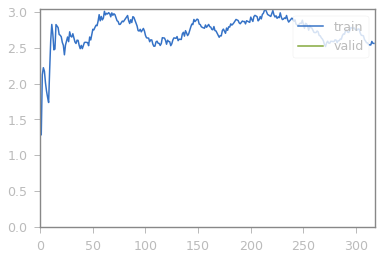

************Round:  9
TTA Accuracy:0.8466846942901611
cycle 2 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977), 30: (0.6449677516124241, 15.691566467285156), 33: (2.3098845057747064, 15.811580419540405), 36: (3.4798260086995603, 15.451544523239136), 39: (4.424778761061942, 15.331530570983887)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 32
Min probability = 0.4298507462686567
Dropped 17 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6355


epoch,train_loss,valid_loss,accuracy,time
0,2.820636,2.488968,0.874902,01:44


Better model found at epoch 0 with accuracy value: 0.8749016523361206.


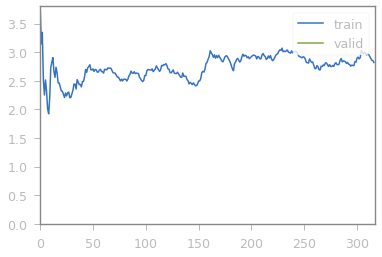

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 28
Min probability = 0.3761194029850746
Dropped 23 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6332


epoch,train_loss,valid_loss,accuracy,time
0,2.639277,2.638023,0.868878,01:43


Better model found at epoch 0 with accuracy value: 0.8688783645629883.


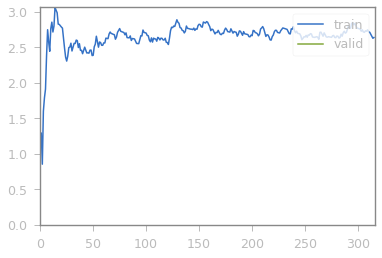

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 23 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6309


epoch,train_loss,valid_loss,accuracy,time
0,2.747013,2.560845,0.871531,01:43


Better model found at epoch 0 with accuracy value: 0.8715305328369141.


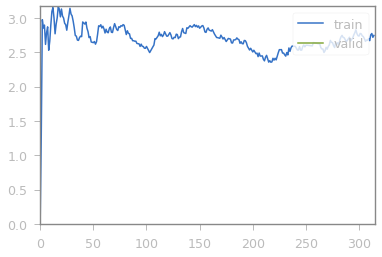

************Round:  12
TTA Accuracy:0.8475847840309143
cycle 2 Error Rate is [{0: (0.7049647517624158, 15.63156247138977), 3: (2.2948852557372112, 15.691566467285156), 6: (3.4798260086995603, 15.811580419540405), 9: (4.5897705114744225, 15.871584415435791), 12: (5.264736763161837, 15.99159836769104), 15: (0.6599670016499193, 16.02160334587097), 18: (2.0698965051747398, 16.321629285812378), 21: (3.269836508174595, 15.781575441360474), 24: (4.454777261136944, 16.141611337661743), 27: (5.2197390130493515, 15.63156247138977), 30: (0.6449677516124241, 15.691566467285156), 33: (2.3098845057747064, 15.811580419540405), 36: (3.4798260086995603, 15.451544523239136), 39: (4.424778761061942, 15.331530570983887), 42: (5.369731513424325, 15.24152159690857)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 14 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6295


epoch,train_loss,valid_loss,accuracy,time
0,2.672084,2.220136,0.889595,01:43


Better model found at epoch 0 with accuracy value: 0.8895949125289917.


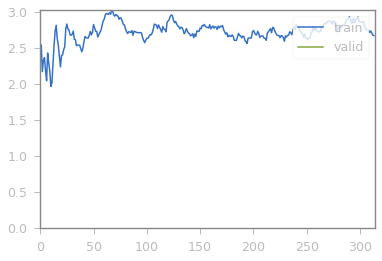

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 25
Min probability = 0.3358208955223881
Dropped 20 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6275


epoch,train_loss,valid_loss,accuracy,time
0,2.555335,2.490760,0.874900,01:43


Better model found at epoch 0 with accuracy value: 0.8749004006385803.


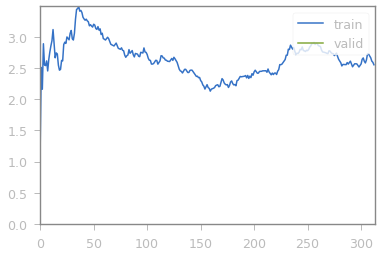

In [33]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
#         print(f'delta = {delta}')
        loss_func = losses.DampedMAELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        k_samples = 50
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

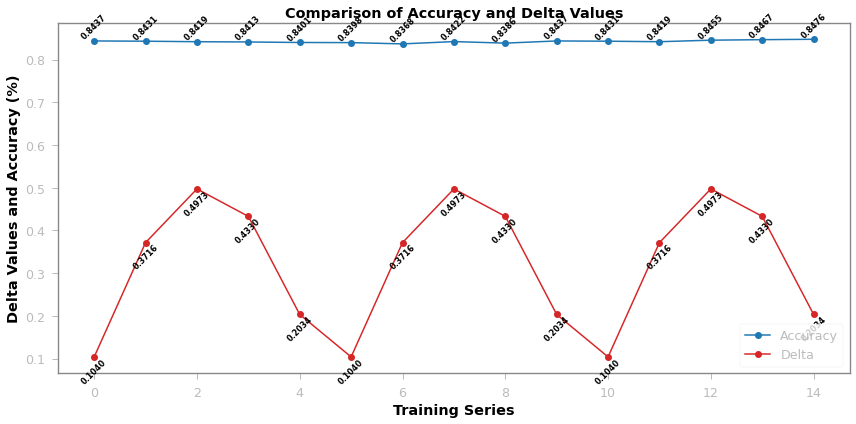

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
